# Unsupervised Book Classification

This project will focus on unsupervised machine learning models to classify various book texts into genres. Since book genres already exist I’m very curious to see the patterns that a machine learning model will pull out of texts as opposed to attempting to classify them into pre-existing themes. The end goal is to be able to offer companies a new and potentially better scheme for labeling books which will aid in consumer recommendation systems. Theoretically, an unsupervised model will be able to see patterns that may not be included in the traditional book genres.

So let's get started!

### Environment Preparation

Following cell include the installs/imports used throughout this project.

In [ ]:
#necessary installs
pip install bsddb3-6.2.7-cp37-cp37m-win_amd64.whl

pip install gutenberg

!python -m textblob.download_corpora

In [ ]:
####WARNING: THIS CELL TAKES ALMOST A DAY TO RUN


#populate the cache so data is available -- 18+ hours to do this
from gutenberg.acquire import get_metadata_cache
cache = get_metadata_cache()
cache.populate()

In [69]:
#all necessary imports 

#general
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np

#gutenberg library specifically designed for extracting from project gutenberg
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
from gutenberg.query import get_etexts
from gutenberg.query import get_metadata

#visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import PIL
import itertools

#natural langugae processing
from textblob import TextBlob
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer

#machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import NMF, LatentDirichletAllocation

#reg expressions
import re

#ignore warnings
import warnings
warnings.filterwarnings("ignore", message="Glyph 13 missing from current font.")

## Get Data

This project focuses on 101 books from Project Gutenburg's library of open source texts. In this branch of the project each book was selected from Gutenberg's top titles and authors.

The first forty books will be used for exploratory data analysis. More books are used for the complete project.

The gap in 'more_books' represents a tentative split for training and testing data where both contain a variety of subject/genre types.

In [3]:
#list of book identification numbers for Project Gutenberg
#hand selected from top 100 books
books = [219, 215, 376, 1342, 11, 514, 98, 43, 76, 
         36, 1952, 2701, 16, 113, 55, 35, 140, 120, 
         158, 1400, 2852, 1184, 768, 1260, 863, 14838, 
         42324, 766, 209, 61620, 1661, 74, 345, 25344, 
         730, 236, 161, 521, 786, 41]

more_books = [219, 215, 376, 1342, 11, 514, 98, 43, 76, 
         36, 1952, 2701, 16, 113, 55, 35, 140, 120, 1204,
         158, 1400, 2852, 1184, 768, 1260, 863, 14838, 
         42324, 766, 209, 61620, 6130, 19942, 1080, 1635,
         147, 1738, 708, 501, 33361, 517, 23625, 30324,
         33, 2097, 1155, 1872, 1917, 2347, 32285,
         1703, 2028, 21530, 21970, 18247, 61564, 51233, 
         12663, 9925, 4984, 13937, 996, 148, 2610,
              
         3335, 1399, 3160, 1661, 74, 345, 730, 236, 161, 521, 
         786, 41, 1497, 3207, 26654, 54, 420, 837, 43048, 
         39549, 1156, 17731, 61168, 3289, 58820, 2688, 
         46153, 159, 31516, 50133, 3268, 34318, 23301, 
         139, 1524, 8799, 15673]

The following function uses the Project Gutenberg Python package to gather each book's title, author, and full text which is then organized in a pandas dataframe from easy access and manipulation. 

In [6]:
#function to create dataframes with texts and metadata
columns = ['Ebook', 'Title', 'Author', 'Text']
def create_df(books):
    
    titles = []
    authors = []
    texts = []

    for book in books:
        titles.append((list(get_metadata('title', book))[0]))
        authors.append(list(get_metadata('author', book))[0])
        texts.append(strip_headers(load_etext(book)).strip())
        
    data = list(zip(more_books, titles, authors, texts))
    df  = pd.DataFrame(data, columns=columns)

    return data

#df for exploratory data analysis (only 40 books)
eda_log = pd.DataFrame(create_df(more_books), columns=columns)

#full set for analysis
catalog = pd.DataFrame(create_df(more_books), columns=columns)

In [7]:
#sorts by author and resets index
eda_log = eda_log.sort_values('Author').reset_index(drop=True)
catalog = catalog.sort_values('Author').reset_index(drop=True)

## Exploratory Data Analysis

Exploring text data is a bit different than numerical. I thought it would be interesting to compare each book and find some differences. I did this using sentiment analysis, book lengths, and wordclouds.

### Sentiment Analysis

This includes looking at the raw polarity and subjectivity of each book. 

Text polarity attempts classify the emotions expressed within the text as generally positive, neutral, or negative. It returns a number between -1 and 1. 

Text subjectivity analysis tries to give a numerical value to describe how objective or subjective the text is. In other words, did the text consist of factual statements (objective) or more emotional and opinionated (subjective). This scale is between 0 and 1, 1 being the most subjective or emotional. 

In [10]:
#use every other book for eda
eda_log = eda_log.iloc[::2, :]

polarity = []
subjectivity = []

#loop thro each book and calculate sentiments, add to lists
for index, row in eda_log.iterrows():
    blobs = TextBlob(row['Text'])
    blob_sentiment = blobs.sentiment
    polarity.append(blob_sentiment[0])
    subjectivity.append(blob_sentiment[1])

#add in columns for sentiments
eda_log.insert(3, 'Polarity', polarity, True)
eda_log.insert(4, 'Subjectivity', subjectivity, True)

#sort and reset index
eda_log = eda_log.sort_values('Author').reset_index(drop=True)

In [16]:
#Rename some books to fit graphs better
eda_log.loc[5, 'Title'] = 'Dorothy + Wizard in Oz'
eda_log.loc[9, 'Title'] = 'Alice in Wonderland'
eda_log.loc[11, 'Title'] = 'Man in Brown Suit'
eda_log.loc[14, 'Title'] = 'The Divine Comedy'
eda_log.loc[15, 'Title'] = 'Journal of Plague Year'
eda_log.loc[20, 'Title'] = 'Dying Detective'
eda_log.loc[21, 'Title'] = 'Hound of Baskervilles'
eda_log.loc[29, 'Title'] = 'Sleepy Hollow'
eda_log.loc[41, 'Title'] = 'T. Roosevelt Autobio'
eda_log.loc[42, 'Title'] = 'Hamlet'
eda_log.loc[44, 'Title'] = 'Dr Jekyll & Mr Hyde'
eda_log.loc[47, 'Title'] = 'Tom Sawyer'
eda_log.loc[50, 'Title'] = 'Isle of Dr Moreau'

The following graph displays each book's polarity. It is interesting to note that even the lowest polarity value, "The Island of Doctor Moreau" is just barely below 0 and the highest, "Ion" by Plato is still quite far from 1.

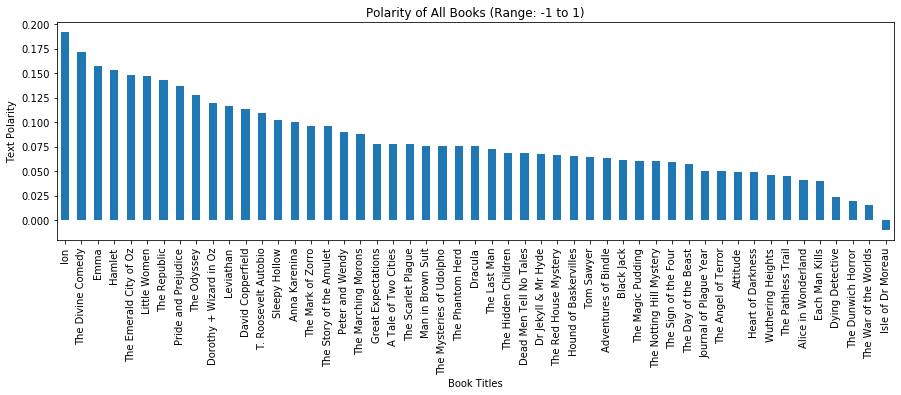

In [18]:
title_df = eda_log.groupby("Title")

plt.figure(figsize=(15,4))
title_df.max().sort_values(by="Polarity",ascending=False)["Polarity"].plot.bar()
plt.title("Polarity of All Books (Range: -1 to 1)")
plt.xlabel("Book Titles")
plt.ylabel("Text Polarity")
plt.show()

As you can see in the below graph there isn’t much range in the subjectivity of the books, where almost all books are just about at the midway point. I find it interesting Theodore Roosevelt's Autobiography is not the lowest text here.

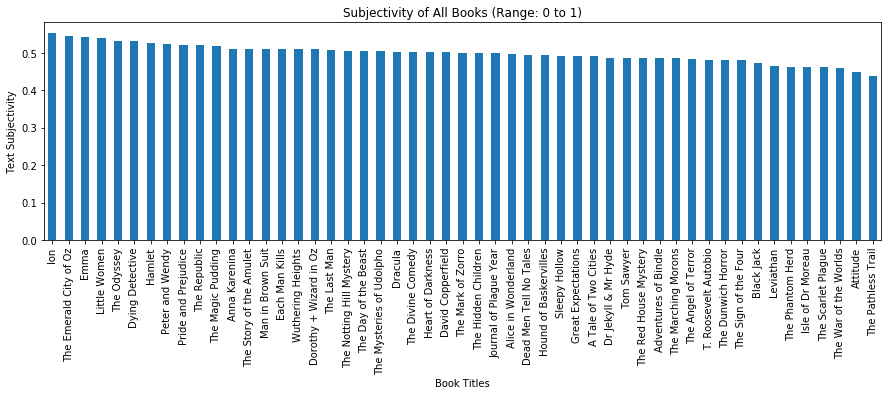

In [19]:
plt.figure(figsize=(15,4))
title_df.max().sort_values(by="Subjectivity",ascending=False)["Subjectivity"].plot.bar()
plt.title("Subjectivity of All Books (Range: 0 to 1)")
plt.xlabel("Book Titles")
plt.ylabel("Text Subjectivity")
plt.show()

### Book Lengths

Count the characters in each book, the following bar graph gives a good idea of the range of the book lengths. 

In [22]:
#create new column for characters
chars = []
for i in range(len(eda_log)):
    chars.append(len(eda_log.Text[i]))
eda_log.insert(6, 'Characters', chars, True)

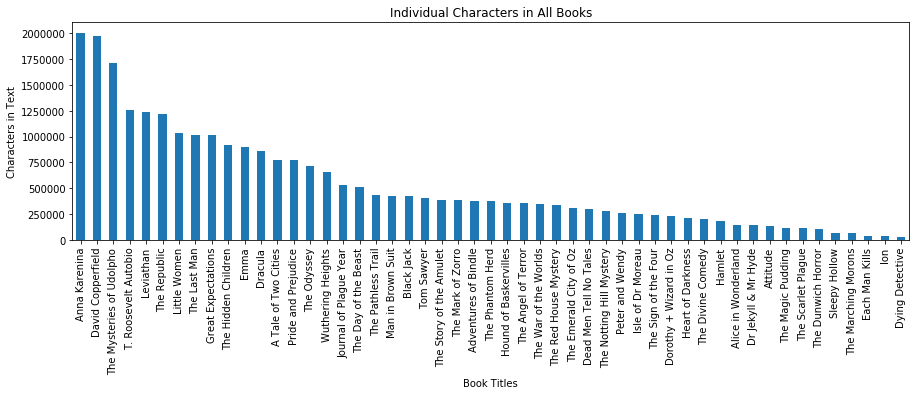

In [24]:
words_df = eda_log.groupby("Title")

plt.figure(figsize=(15,4))
words_df.max().sort_values(by="Characters",ascending=False)["Characters"].plot.bar()
plt.title("Individual Characters in All Books")
plt.xlabel("Book Titles")
plt.ylabel("Characters in Text")
plt.show()

### Wordclouds
An easy visual way to see what words pop up the most in books. The first cloud shows top words in all books and the following are the most polar and longest/shortest books.

In [25]:
#common words to take out
stopwords = set(STOPWORDS)
stopwords.update(['one', 'illustration', 'illustrated'])

There are 27198221 characters in the combination of all books.


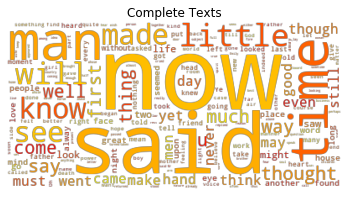

In [66]:
complete = " ".join(review for review in eda_log.Text)
print ("There are {} characters in the combination of all books.".format(len(complete)))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color=None, colormap="autumn", mode='RGBA').generate(complete)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Complete Texts')
plt.show()

In [28]:
#function to creat wordclouds
def plot_wordcloud(number):
    wordcloud = WordCloud(stopwords=stopwords, width=400, height=200, background_color=None, mode='RGBA', 
                          random_state=5).generate(eda_log.Text[number])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    #use sentiments dataframe for shortened titles
    plt.title(f'{eda_log.Title[number]} by {eda_log.Author[number]}')

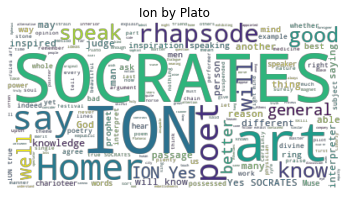

In [31]:
plot_wordcloud(38)

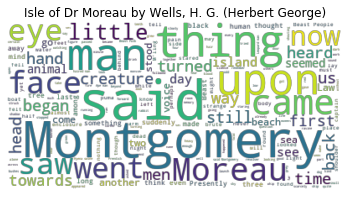

In [32]:
plot_wordcloud(50)

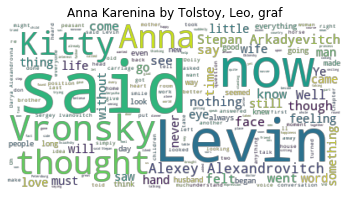

In [33]:
plot_wordcloud(46)

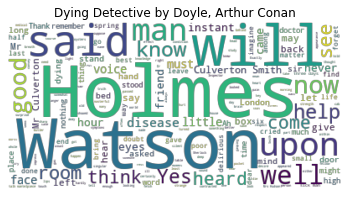

In [34]:
plot_wordcloud(20)

## Cleaning
Books contain a lot of noise and inconsistencies which can include uppercase letters, various punctuation, and different forms of words (plural, past-tense, etc).

Texts also have a lot of words that don't necessarily add any substance to classifying models; these are known as 'stop-words'. Stop-words include 'the', 'and', 'a', and many more. These are usually just removed from texts to remove the noise and increase speed.

The case of letters can create issues as python will read "Snakes" as a different word from "snakes" however this can also change the meaning of words; for example with acronyms like "US" as a country versus "us". 'Immigrate to the US with us!' Most often the simplest solution is to bring all the letters to lowercase and accept the inaccuracies that will occur.

Punctuation will also have a large effect on the meaning of a sentence and this is another topic that machine learning models will struggle with and will often have negative outcomes on predictability. Generally punctuation is completely removed.

The following section is focused on standardizing each book to make it easier for the machine learning models to classify the genres.

Note: I've included the time each segment took to run - it varies greatly and gives helpful insight to the amount of work each cell is doing.

### Unwanted Character Removal
Using a regular expression this is a very fast process (less than 3 seconds to process 101 entire books).

In [36]:
%%time
#remove unwanted punctuation and numbers
for i in range(len(catalog)):
    catalog.at[i, 'Text'] = re.sub('[?!@#$1234567890''""”“’]', '', catalog.loc[i, 'Text'])

Wall time: 2.1 s


### Tokenization
This process separates the text as a single string into individual words that will be easier to process and understand for the models. Another technique is the use of n-grams which are strings of n words that often improve analysis. Example: "I'm not surprised!" as 'im', 'not', 'surprised' vs 'im', 'not surprised' - each of these can have very different effects when used as input to a ML algorithm.  n-grams may be implemented later to compare. 

In [37]:
%%time
#separates each word in each text to its own string
#this creates a type of textblob.blob.WordList
for i in range(len(catalog)):
    catalog.at[i, 'Text'] = (TextBlob(catalog.loc[i, 'Text']).lower()).words

Wall time: 6min 53s


### Removing Stop-Words
Since all the words have been individually wrapped into their own strings it is now easier to remove any stop-words that are present to reduce noise and increase processing speeds with minimum effects on classification.

In [38]:
%%time
#add words and characters (that escaped reg ex removal) to the nltk stopword list
stop_words.append('”')
stop_words.append('“')
stop_words.append('chapter')
stop_words.append('’')
stop_words.append('[')
stop_words.append(']')
stop_words.append('illustration')
stop_words.append('illustrated')

for i in range(len(catalog)):
    catalog.at[i, 'Text'] = [text for text in catalog.loc[i, 'Text'] if text not in stop_words]

Wall time: 1min 2s


### Adding POS Tags
This step is necessary in order for the following lemmatization to occur properly. Each word within the texts will be tagged with a part of speech, verb = 'VB', noun = 'NN', etc. This will help the model better understand the words and their context.

In [39]:
%%time
#tagging takes awhile as it has to access multiple locations and cross reference
for i in range(len(catalog)):
    catalog.at[i, 'Text'] = [TextBlob(text).tags for text in catalog.loc[i, 'Text']]

Wall time: 2h 51min 34s


### Word Normalization - Lemmatizing

Since this project is focused on unsupervised ML to classify genres, language and context is important between texts
so lemmatization was chosen over stemming. While speed is not currently a concern at this point, the use 
of stemming may be explored later on if this is applied to a larger database. Lemmatizing also provides 
more readability if necessary while going through this project.

In [40]:
#initialize lematizer
lemma = WordNetLemmatizer()

#function to map tags to pos that the lemmatizer will accept
#bases off first character of the tag
def get_wordnet_pos(letter):
    tag_dict = {"J": wordnet.ADJ,
                "S": wordnet.ADJ,
                "C": wordnet.NOUN,
                "E": wordnet.NOUN,
                "F": wordnet.NOUN,
                "M": wordnet.NOUN,
                "I": wordnet.NOUN,
                "L": wordnet.NOUN,
                "N": wordnet.NOUN,
                "D": wordnet.NOUN,
                "P": wordnet.NOUN,
                "R": wordnet.NOUN,
                "T": wordnet.VERB,
                "U": wordnet.NOUN,
                "V": wordnet.VERB,
                "W": wordnet.ADV,
                "R": wordnet.ADV}
    
    return tag_dict.get(letter, "")

In [41]:
%%time
#lemmatize
for i in range(len(catalog)):
    for x in range(len(catalog.loc[i, 'Text'])):
            catalog.at[i, 'Text'][x] = [lemma.lemmatize((catalog.loc[i, 'Text'][x][0][0]), get_wordnet_pos((catalog.loc[i, 'Text'][x][0][1][0]))) 
                                for text in catalog.loc[i, 'Text'][x]]

Wall time: 11min 19s


## Machine Learning
Now the fun part!

In the machine learning portion I decided to use a tf idf vectorizer and look at two clustering algorithms- a KMeans model and an Agglomerative Hierarchical model with a bonus topic clusterer - non-negative matric factorization "NMF".

#### Simplify 
To make the data a bit easier to work with the texts are reduced to simpler form.

In [42]:
#converts list of lists to list of texts (tokenized)
for i in range(len(catalog)):
    catalog.at[i, 'Text'] = [word for nested in catalog.loc[i, 'Text'] for word in nested]
    
#turn text lists into plain text
catalog.Text=[" ".join(words) for words in catalog['Text'].values]

Wall time: 2.27 s


#### Train / Test Split
The full book catalog is split into a training set and a testing set. While this is generally done randomly I opted to manually split them to ensure a varied testing set. When revisited with a larger set of data this will be done randomly. This worked out to be a 77/23, train/test split.

In [85]:
#split into training and testing dataframes
train_catalog = catalog.iloc[[0, 1, 2, 4, 5, 7, 9, 10, 11, 12, 14, 16, 17, 
                              18, 19, 20, 21, 22, 24, 25, 26, 28, 29, 31, 
                              32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 
                              45, 46, 47, 49, 51, 52, 53, 55, 56, 57, 59,
                              60, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73,
                              74, 75, 76, 77, 79, 80, 81, 83, 84, 85, 87,
                              88, 90, 91, 92, 93, 95, 96, 98, 99]]

test_catalog = catalog.iloc[[3, 8, 13, 15, 23, 27, 30, 35, 41, 48, 50, 54, 
                             58, 61, 67, 68, 78, 82, 86, 89, 94, 97, 100]]

In [86]:
#reset index for both to increase loop efficiency
train_catalog = train_catalog.reset_index(drop=True)
test_catalog = test_catalog.reset_index(drop=True)

In [88]:
#rename some books for nicer display
test_catalog.at[1, 'Title'] = 'Ozma of Oz'
test_catalog.at[5, 'Title'] = 'The Nigger of The "Narcissus"'
test_catalog.at[6, 'Title'] = 'A Journal of the Plague Year'

### Tfidf Vectorizer
Since it is very difficult to directly compare words, a common practice is to vectorize the data before beginning any type of maching learning.

I use the Tf idf Vectorizer from sklearn to turn each book into an array of vectors that the ML clustering models can easily interpret. The term frequency, inverse document frequence (tf idf) Vectorizer increases values proportionally to count, but is offset by the frequency of the word in the corpus (collection of words that are present). This helps to adjust for the fact that some words appear more frequently.

In [90]:
#vectorize
vectorizer = TfidfVectorizer()

train_vectors = vectorizer.fit_transform(train_catalog.Text)
test_vectors = vectorizer.transform(test_catalog.Text)

### KMeans
One of the simplest, most common, and often most accurate clustering model. This chooses k (number of clusters) random positions and assigns a cluster center for each. The data is split between these by assigning the data point (vectors in this case) to the nearest cluster center or centroid. Decision boundaries are set for each centroid. The centroid is then updated to be in the middle of the data within the decision boundary. This is repeated until clusters are fully centered around each centroid (or as close as possible). 

The following graphs help decide on the optimal number of clusters. A general rule is around the square root of the number of data points, which in this case is ~10. 

Let's take a closer look - first, an attempt at finding an elbow in the slew of possible k values ranging from 1 to 50. There is no obvious winner, but it looks like a slight change in steepness around 6 and 19 clusters - going too high can develop into overfitting.

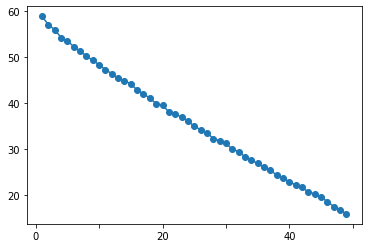

In [48]:
#evaluating number of clusters 
ks = range(1,50)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(train_vectors)
    inertias.append(model.inertia_)

fig, ax = plt.subplots(1,1)
ax.plot(ks, inertias, '-o')
for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)
plt.show()

Silhouette Score for n = 4: 0.03788939626377465
Silhouette Score for n = 5: 0.022442601533582063
Silhouette Score for n = 6: 0.006359777498229408
Silhouette Score for n = 7: 0.0034744797494738336
Silhouette Score for n = 8: 0.015660054903741776
Silhouette Score for n = 9: 0.0071181863665264085


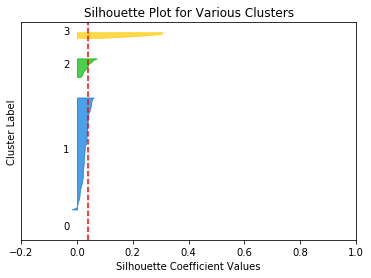

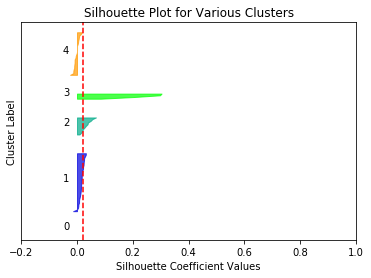

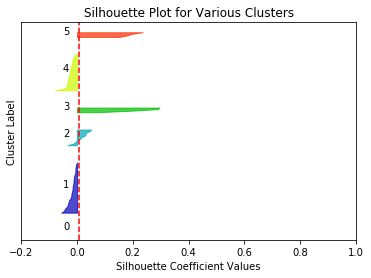

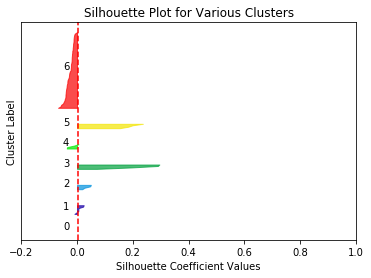

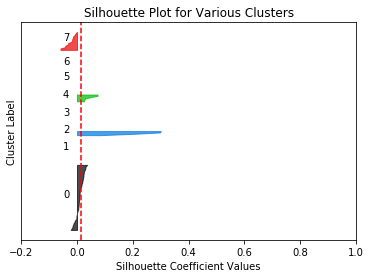

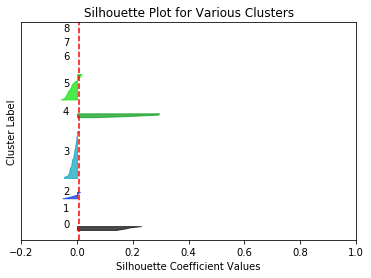

In [49]:
#print silhouette scores and plot each one
ks = range(4,10)

for n in ks:
    # Make plot
    fig, ax = plt.subplots(1, 1)
    ax.set_xlim([-0.2, 1])
    
    # Set up KMeans model and predictions
    model = KMeans(n_clusters=n, random_state=5)
    cluster_labels = model.fit_predict(train_vectors)
    
    # Print avg silhouette score for n
    sil_score = silhouette_score(train_vectors, cluster_labels)
    print("Silhouette Score for n = " + str(n) + ": " + str(sil_score))
    
    # Compute silhouette score for each sample
    sample_sil_vals = silhouette_samples(train_vectors, cluster_labels)

    y_lower = 10
    
    # collect silhouette scores for each cluster, sort
    for i in range(n):
        # Get silhouette values for the ith cluster
        ith_cluster_sil_vals = sample_sil_vals[cluster_labels == i]
        ith_cluster_sil_vals.sort()
    
        # How many samples in the cluster?
        size_cluster_i = ith_cluster_sil_vals.shape[0]
    
        # Formatting for the figure
        y_upper = y_lower + size_cluster_i
    
        # Put bars on the graph
        color = cm.nipy_spectral(float(i) / n)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_sil_vals,
                    facecolor=color, edgecolor=color, alpha=0.7)
    
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
        # Visible offset for the next cluster on the figure
        y_lower = y_upper + 10
        
    ax.set_title("Silhouette Plot for Various Clusters")
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Label")

    ax.set_yticks([])
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Draw line for the average silhouette value
    ax.axvline(x=sil_score, color='red', linestyle='--')

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

Silhouette scores can be a useful measurement - they are indicating the optimal number of clusters will be around 4 or 5.

In [130]:
#kmeans model
#number of clusters
clusters = 5
#initiate model and fit to training vectors
kmean_model = KMeans(n_clusters=clusters, random_state=0).fit(train_vectors)

#transform test vectors to fit model and make array
test_labels = []
for i in range(len(test_catalog)):
    predicted = kmean_model.predict(test_vectors[i])
    test_labels.append(predicted[0])
    
kmean_test_labels = np.array(test_labels)

Here we can see the top words defining each cluster. Looking at this it might be worth it to add some more vocabulary to the stop words list to be removed; such as "come" and "would". It also looks like there were enough L. Frank Baum books to have their own Oz land cluster (5) along with cluster 4 for Sherlock and Watson's mysteries.

In [131]:
#prints top words defining each cluster
order_centroids = kmean_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind])

Cluster 0:
 peter
 wendy
 mcgregor
 mr
 say
Cluster 1:
 one
 say
 make
 would
 come
Cluster 2:
 dorothy
 scarecrow
 oz
 say
 wizard
Cluster 3:
 señor
 zorro
 diego
 señorita
 gonzales
Cluster 4:
 say
 go
 one
 mr
 come


Since this is unsupervised learning there is no metric to measure by except our own knowledge and understanding. Below is a selection of test books along with their predicted cluster - we can compare these predictions to the words and labels from the fitted model on the training set of books. We can see Ozma of Oz fits right where we'd expect it to. Cluster 4 seems to dominate even in this slice of the test books, this is most likely due to the generic nature of the words that make up the cluster.

In [132]:
#unnecessary but interesting
#prints predicted clusters and title of each book
print("Prediction")
for i in range(9):
    print(kmean_test_labels[i], test_catalog.Title[i])

Prediction
4 Sense and Sensibility
2 Ozma of Oz
4 Cabin Fever
4 Jane Eyre: An Autobiography
4 The Mysterious Affair at Styles
4 The Nigger of The "Narcissus"
1 A Journal of the Plague Year
4 David Copperfield
4 The Adventures of Sherlock Holmes


### Hierarchical
Agglomerative clustering is a bottom-up approach. Each book is put into its own cluster and the next closest clusters are then grouped together. This goes on until all books are in a single cluster or when it reaches the number of desired clusters.

The two graphs below show average linkage and ward linkage. Average uses the average of the distances of each observation of the two sets. Ward minimizes the variance of the clusters being merged.

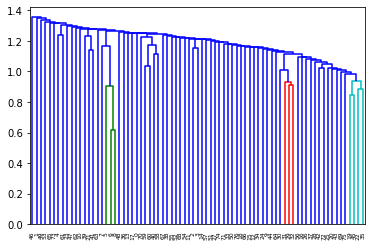

In [54]:
#average linkage
mergings = linkage(train_vectors.toarray(), method='average')
dendrogram(mergings, leaf_rotation=90, leaf_font_size=6)
plt.show()

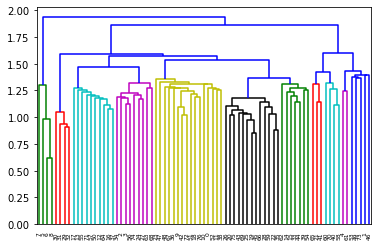

In [72]:
#ward linkage
mergings = linkage(train_vectors.toarray(), method='ward')
dendrogram(mergings, leaf_rotation=90, leaf_font_size=6)
plt.show()

Ward linkage looks like it does a much better job dividing the books into various genres. It looks like it initially splits into 7 different hierarchies so let's start there.

In [135]:
#initiate and fit model to train data
hier_model = AgglomerativeClustering(n_clusters=7, linkage='ward').fit(train_vectors.toarray())

#predict for test data
hier_test_labels = AgglomerativeClustering(n_clusters=6, linkage='ward').fit_predict(test_vectors.toarray())

print('Training Labels:')
for i in range(10):
    print(hier_model.labels_[i], train_catalog.Title[i])

Training Labels:
6 Little Women
2 The Piebald Hippogriff
0 Pride and Prejudice
0 Emma
2 Peter Pan
3 Dorothy and the Wizard in Oz
3 The Wonderful Wizard of Oz
3 The Marvelous Land of Oz
3 The Emerald City of Oz
6 The Phantom Herd


In [136]:
print('Predicted Labels:')
for i in range(15):
    print(hier_test_labels[i], test_catalog.Title[i])

Predicted Labels:
1 Sense and Sensibility
5 Ozma of Oz
0 Cabin Fever
1 Jane Eyre: An Autobiography
1 The Mysterious Affair at Styles
4 The Nigger of The "Narcissus"
4 A Journal of the Plague Year
1 David Copperfield
1 The Adventures of Sherlock Holmes
4 Each Man Kills
0 The Mysterious Rider
3 The Odyssey
4 The Legend of Sleepy Hollow
4 The Jungle Book
0 The Call of the Wild


Looking at a slice of the training labels and predicted test labels, there are a few surprises. The model ended with 6 clusters rather than 7 (not all are shown). While it trained all the Oz books into cluster 3, it put Ozma of Oz into cluster 5. It also put an adventure book (Call of the Wild) in with Pride and Prejudice & Emma. 

From a glance it doesn't appear as if this model did a very good job.

### Non-negative Matrix Factorization
NMF is not a traditional cluster algorithm but a topic clusterer and dimension reducer. After fitting to the training set it creates different topics and expresses each book as a combination of these topics - like variable coefficients. 

In [98]:
#function to print out top words for each topic in NMF model
n_top_words = 10

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [99]:
#get words from tfidf vectorizer
tfidf_feature_names = vectorizer.get_feature_names()

In [137]:
#out of box model
nmf_model = NMF(n_components=6, random_state=5).fit(train_vectors)

#top words for out of box model
print('Out of Box Model:')
print_top_words(nmf_model, tfidf_feature_names, n_top_words)

Out of Box Model:
Topic #0: one go come say could would get make time see
Topic #1: one hath thou make may say socrates thy would man
Topic #2: dorothy oz scarecrow say wizard ozma woodman zeb nome emerald
Topic #3: mr say would go could come look one know emma
Topic #4: holmes watson say upon man mcmurdo one would sir well
Topic #5: say go dont get see one come well know look



In [138]:
#Frobenius norm model
#The Frobenius norm can be considered as a vector norm, 
#defined as the square root of the sum of the absolute squares of its elements
frob_nmf = NMF(n_components=6, random_state=5,
          alpha=.1, l1_ratio=.5).fit(train_vectors)

print('Frobenius Norm Model:')
print_top_words(frob_nmf, tfidf_feature_names, n_top_words)

Frobenius Norm Model:
Topic #0: say one go come would make could see time get
Topic #1: hamlet horatio polonius laertes rosencrantz ophelia guildenstern lord king marcellus
Topic #2: dorothy oz scarecrow wizard ozma woodman zeb nome toto emerald
Topic #3: bindle mr wot earty hearty stiffson millie ai gupperduck macfie
Topic #4: holmes watson upon baskerville culverton man mcmurdo sir stapleton barrymore
Topic #5: puddin bunyip bill possum bluegum say thieves sam wombat owners



In [139]:
#generalized Kullback-Leibler divergence
#handled by explicit normalization of one of the matrices
kull_nmf = NMF(n_components=6, random_state=5,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(train_vectors)

print('Kullback-Leibler Divergence Model:')
print_top_words(kull_nmf, tfidf_feature_names, n_top_words)

Kullback-Leibler Divergence Model:
Topic #0: young youth way window wife wink whole whose whether ask
Topic #1: dissolve austerity fourths supplant prudence wood frequent capability besmear favorable
Topic #2: cloth bravely chasm cheer branch butcher chariot blew bread prisoner
Topic #3: bill harm chose uncertainty hitherto farthing agree unfolded within assume
Topic #4: beards deep brow dearest civilize bishareen come wire borderer axe
Topic #5: babylon carrot olympus world broaden fillip comin aster woodland worm



While these models are not being used to predict on the test set it is very interesting to see the top words for each model that it creates out of the training set of books and the variety of words between each version. The out of box model seems to match up more with the KMeans model and recognizable book elements are easily seen; this is much less true for the two defined models of Frobenius Norm and Kullback-Leibler.

### Estimate Accuracy
While, as previously stated, unsupervised models have no exact metrics for evaluating results I decided to create my own for this specific book project to estimate the accuracy of each predicted cluster.

The next 3 functions are a similar iteration of the original process on the book data, but instead I am retrieving and cleaning the subjects of each book from Project Gutenberg (subject example below). The first function acquires all necessary data and puts it into a new dataframe. The second manually adds in the subject for "The Mark of Zorro" due to some kind of bug in the Gutenberg library and the third does a full text process of each book subject.

The final function in this section takes one test book at a time and compares the words in its subject with ALL of the words in each subject of the training book set for the same cluster of the test book. It then calculates the percentage of words found in the training set that were also in the test book's subject. 

For example, if the test book Ozma of Oz is placed into cluster 3, the function pulls all the training books that were also in cluster 3 and takes each word in each subject to compare to the subject of Ozma of Oz. The resulting percentage is the amount of words the test subject shares with the training subjects.

While this is not a perfect accuracy system it works nicely as a general estimated metric to see prediction quality.

In [104]:
#example of a Project Gutenberg book subject 
#Alice's Adventures in Wonderland

#PR and PZ are classifications given by the Library of Congress
#PR = language and literatures: English Lit
#PZ = language and literatures: Juvenile Belles Lettres

get_metadata('subject', 11)

frozenset({'Alice (Fictitious character from Carroll) -- Juvenile fiction',
           "Children's stories",
           'Fantasy fiction',
           'Imaginary places -- Juvenile fiction',
           'PR',
           'PZ'})

#### Create dataframes for books that includes the clusters and subjects of each book

In [105]:
#function to loop thro labels and add subjects to dataframe
def book_subjects(newdf, olddf, labels_):
    olddf = olddf.reset_index(drop=True)
    
    clusters = list(labels_)
    subjects = list()
    
    for i in range(len(labels_)):
        subjects.append(list(get_metadata('subject', olddf.Ebook[i])))
    
    newdf.insert(3, 'Cluster', clusters, True)
    newdf.insert(4, 'Subject', subjects, True)

    return newdf

#### Process text for subjects of each book

In [106]:
#add in mark of zorro subject info
def zorro_subject(df):
    df.at[53, 'Subject'] = ['PS: Language and Literatures: American and Canadian literature', 
                                         'Subject	Western stories', 
                                         'Subject	Aristocracy (Social class) -- Fiction', 
                                         'Subject	California -- Fiction', 
                                         'Subject	Vigilantes -- Fiction', 
                                         'Subject	Spaniards -- California -- Fiction', 
                                         'Subject	Zorro (Fictitious character) -- Fiction']

In [107]:
#function to process book subjects
def text_process(df):
    
    for i in range(len(df)):
        df.at[i, 'Subject'] = " ".join(df.loc[i, 'Subject'])
    
    for i in range(len(df)):
        df.at[i, 'Subject'] = re.sub('[?!@#$1234567890''""”“’]', '', df.loc[i, 'Subject'])
    
    for i in range(len(df)):
        df.at[i, 'Subject'] = set((TextBlob(df.loc[i, 'Subject']).lower()).words)
    
    #add words and characters (that escaped reg ex removal) to the nltk stopword list
    stop_words.append('”')
    stop_words.append('“')

    for i in range(len(df)):
        df.at[i, 'Subject'] = [text for text in df.loc[i, 'Subject'] if text not in stop_words]
        
    for i in range(len(df)):
        df.at[i, 'Subject'] = [TextBlob(text).tags for text in df.loc[i, 'Subject']]
    
    #initialize lematizer
    lemma = WordNetLemmatizer()

    #function to map tags to pos that the lemmatizer will accept
    #bases off first character of the tag
    def get_wordnet_pos(letter):
        tag_dict = {"J": wordnet.ADJ,
                    "S": wordnet.ADJ,
                    "C": wordnet.NOUN,
                    "E": wordnet.NOUN,
                    "F": wordnet.NOUN,
                    "M": wordnet.NOUN,
                    "I": wordnet.NOUN,
                    "L": wordnet.NOUN,
                    "N": wordnet.NOUN,
                    "D": wordnet.NOUN,
                    "P": wordnet.NOUN,
                    "R": wordnet.NOUN,
                    "T": wordnet.VERB,
                    "U": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "W": wordnet.ADV,
                    "R": wordnet.ADV}

        return tag_dict.get(letter, "")
    
    #lemmatize
    for i in range(len(df)):
        for x in range(len(df.loc[i, 'Subject'])):
                df.at[i, 'Subject'][x] = [lemma.lemmatize((df.loc[i, 'Subject'][x][0][0]), 
                                         get_wordnet_pos((df.loc[i, 'Subject'][x][0][1][0]))) 
                                         for text in df.loc[i, 'Subject'][x]]
                
    #converts list of lists to list of texts (tokenized)
    for i in range(len(df)):
        df.at[i, 'Subject'] = [word for nested in df.loc[i, 'Subject'] for word in nested]
    
    return df

#### Compare words in subjects for each book between train and test dataframes based on clusters

In [108]:
def compare_cluster_subjects(test, train, only_avg=True, desc=True):
    
    if desc == True:
        print('These percentages are an estimated accuracy for each predicted cluster placement. \n\
They are based on the number of matching words in the genre/subjects of the individual\n\
test book and the entirety of subjects from a single cluster of training book.\n')
    total = 0
    for book in range(len(test)):   #loops through each book in test set
        test_cluster_words = []   #lists of test and train words to compare
        train_cluster_words = []
        for word in test.Subject[book]:
            test_cluster_words.append(word)

        #adds all words from each train book subject from a single cluster to a list
        for subject in (train.Subject.loc[train['Cluster'] == test.Cluster[book]]):
            for word in subject:
                train_cluster_words.append(word)

        #calculates similarity between test book subject and entire train cluster subject
        similarity = 0
        for word in set(test_cluster_words):
            if word in set(train_cluster_words):
                similarity += 1
          
        score = (similarity / len(test_cluster_words))*100
    
        total += score
        if only_avg == False:
            print(f'\n {test.Author[book]} -- {test.Title[book]} \n Accuracy: {score:.2f}% \n')  
    
    #calculates average score from all test books
    avg_score = total/len(test)
    print(f'Average Accuracy: {avg_score:.2f}%')

Potential pitfalls for this estimated accuracy test include:
 - The bigger the training set is the more likely 'accuracy' will increase
     - A similar affect with fewer clusters as more words to compare to are in each cluster
 - Subjects retrieved from Project Gutenberg are kinda weird (often overly specific)
 - Subjects are sometimes very short making it easy for 100% of the words to show up in trained clusters

### Accuracy Pipeline Function
Simplifies process to one function. Only required inputs are the trained model and the predicted labels. Can elect to print out only average scores or each test book's individual score.

In [109]:
#average accuracy
def accuracy_pipeline(train_model, test_labels, only_avg=True):
    #create dataframes
    train_df = train_catalog[['Ebook', 'Title', 'Author']]
    train_df = book_subjects(train_df, train_catalog, train_model.labels_)
    test_df = test_catalog[['Ebook', 'Title', 'Author']]
    test_df = book_subjects(test_df, test_catalog, test_labels)
    
    #add zorro subject to training set
    zorro_subject(train_df)
    
    #process text
    text_process(train_df)
    text_process(test_df)
    
    #get avg accuracy
    if only_avg == True:
        compare_cluster_subjects(test_df, train_df, True, False)
    else:
        compare_cluster_subjects(test_df, train_df, False, True)

## Model Comparisons
Now that we have a way to objectively compare the predictions let's find the best scores.

The first two compare average scores for a range of cluster values for KMeans and Hierarchical clustering.

#### Average Estimated Accuracies for a range of clusters

In [119]:
#loops through 1-10 clusters and prints each average estimated accuracy
print('KMeans Model')
k_values = range(1, 11)
for cluster in k_values:
    #initiate model and fit to training vectors
    kmean_model = KMeans(n_clusters=cluster, init='k-means++', max_iter=300, n_init=1, random_state=0).fit(train_vectors)
    
    #transform test vectors to fit model and make array
    test_labels = []
    for i in range(len(test_catalog)):
        predicted = kmean_model.predict(test_vectors[i])
        test_labels.append(predicted[0])
    
    kmean_test_labels = np.array(test_labels)
    
    print(f'\n       {cluster} clusters')
    accuracy_pipeline(kmean_model, test_labels)

KMeans Model

       1 clusters
Average Accuracy: 82.47%

       2 clusters
Average Accuracy: 80.51%

       3 clusters
Average Accuracy: 82.07%

       4 clusters
Average Accuracy: 81.86%

       5 clusters
Average Accuracy: 81.65%

       6 clusters
Average Accuracy: 81.45%

       7 clusters
Average Accuracy: 81.45%

       8 clusters
Average Accuracy: 70.66%

       9 clusters
Average Accuracy: 70.66%

       10 clusters
Average Accuracy: 70.66%


In [114]:
#hierarchical cluster comparisons
print("Hierarchical Model")
k_values = range(1, 11)
for cluster in k_values:
    #initiate model
    hier_model = AgglomerativeClustering(n_clusters=cluster, linkage='ward').fit(train_vectors.toarray())
    
    #predict test books
    hier_test_labels = AgglomerativeClustering(n_clusters=6, linkage='ward').fit_predict(test_vectors.toarray())
    
    print(f'\n       {cluster} clusters')
    accuracy_pipeline(hier_model, hier_test_labels)

Hierarchical Model

       1 clusters
Average Accuracy: 10.60%

       2 clusters
Average Accuracy: 14.27%

       3 clusters
Average Accuracy: 15.39%

       4 clusters
Average Accuracy: 16.21%

       5 clusters
Average Accuracy: 26.13%

       6 clusters
Average Accuracy: 27.17%

       7 clusters
Average Accuracy: 24.13%

       8 clusters
Average Accuracy: 26.30%

       9 clusters
Average Accuracy: 24.85%

       10 clusters
Average Accuracy: 18.16%


It's clear KMeans beats out Hierarchical no matter the number of clusters. Lets take a look at individual book scores for each anyway.

#### Individual Book Accuracies
These printouts look at the average estimated accuracies of each individual book using the optimal number of clusters for both models.

In [144]:
#kmeans accuracy
kmean_model = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=1, random_state=0).fit(train_vectors)
#transform test vectors to fit model and make array
test_labels = []
for i in range(len(test_catalog)):
    predicted = kmean_model.predict(test_vectors[i])
    test_labels.append(predicted[0])
    
kmean_test_labels = np.array(test_labels)

accuracy_pipeline(kmean_model, kmean_test_labels, False)

These percentages are an estimated accuracy for each predicted cluster placement. 
They are based on the number of matching words in the genre/subjects of the individual
test book and the entirety of subjects from a single cluster of training book.


 Austen, Jane -- Sense and Sensibility 
 Accuracy: 85.71% 


 Baum, L. Frank (Lyman Frank) -- Ozma of Oz 
 Accuracy: 90.00% 


 Bower, B. M. -- Cabin Fever 
 Accuracy: 100.00% 


 Brontë, Charlotte -- Jane Eyre: An Autobiography 
 Accuracy: 89.47% 


 Christie, Agatha -- The Mysterious Affair at Styles 
 Accuracy: 76.92% 


 Conrad, Joseph -- The Nigger of The "Narcissus" 
 Accuracy: 68.75% 


 Defoe, Daniel -- A Journal of the Plague Year 
 Accuracy: 81.82% 


 Dickens, Charles -- David Copperfield 
 Accuracy: 83.33% 


 Doyle, Arthur Conan -- The Adventures of Sherlock Holmes 
 Accuracy: 92.31% 


 Glad, Victoria -- Each Man Kills 
 Accuracy: 100.00% 


 Grey, Zane -- The Mysterious Rider 
 Accuracy: 100.00% 


 Homer -- The Odyssey 
 Ac

In [146]:
#hierarchical accuracy
#initiate model
hier_model = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(train_vectors.toarray())
    
#predict test books
hier_test_labels = AgglomerativeClustering(n_clusters=6, linkage='ward').fit_predict(test_vectors.toarray())
    
accuracy_pipeline(hier_model, hier_test_labels, False)

These percentages are an estimated accuracy for each predicted cluster placement. 
They are based on the number of matching words in the genre/subjects of the individual
test book and the entirety of subjects from a single cluster of training book.


 Austen, Jane -- Sense and Sensibility 
 Accuracy: 19.05% 


 Baum, L. Frank (Lyman Frank) -- Ozma of Oz 
 Accuracy: 30.00% 


 Bower, B. M. -- Cabin Fever 
 Accuracy: 100.00% 


 Brontë, Charlotte -- Jane Eyre: An Autobiography 
 Accuracy: 10.53% 


 Christie, Agatha -- The Mysterious Affair at Styles 
 Accuracy: 15.38% 


 Conrad, Joseph -- The Nigger of The "Narcissus" 
 Accuracy: 25.00% 


 Defoe, Daniel -- A Journal of the Plague Year 
 Accuracy: 27.27% 


 Dickens, Charles -- David Copperfield 
 Accuracy: 8.33% 


 Doyle, Arthur Conan -- The Adventures of Sherlock Holmes 
 Accuracy: 23.08% 


 Glad, Victoria -- Each Man Kills 
 Accuracy: 28.57% 


 Grey, Zane -- The Mysterious Rider 
 Accuracy: 100.00% 


 Homer -- The Odyssey 
 Accu

KMeans seems to generally a better job with mystery/horror than it does some of the adventure, longer texts, and the autobiography. However, The Call of the Wild is the lowest scoring (31.25%) and there are quite a few similar books in the training set. 

Within the Hierarchical model, there are quite a few books between 0% and 20% accuracy. Each of these books have very similar counterparts in the training set, especially Ozma of Oz (5 training Land of Oz books). This model does surprisingly poorly on the data.

## Future Work
There are quite a few ideas and concepts that I would like to further explore later on in attempts to better understand and improve unsupervised classifiers for books.

- Larger and more diverse dataset
- N-gram model
- Latent Dirichlet Allocation
- Dimensionality Reduction
- Improve accuracy estimator with better genre descriptions

#### Thanks for your interest! If you have any questions, comments, or concerns, please feel free to contact me at evan.j.hintz@gmail.com !